# Custom Architecture

In [1]:
# Imports and Setup

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


cuda


In [2]:
# Data Preparation

# Transformations for training and testing
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
])

# Datasets and loaders
trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)
trainloader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=4)

testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)
testloader = DataLoader(testset, batch_size=100, shuffle=False, num_workers=4)

print(f"Training samples: {len(trainset)}, Test samples: {len(testset)}")


Files already downloaded and verified
Files already downloaded and verified
Training samples: 50000, Test samples: 10000


In [3]:
# Model Definition

class CustomCNN(nn.Module):
    def __init__(self):
        super().__init__()
        # Convolutional blocks
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.conv4 = nn.Conv2d(256, 256, 3, padding=1)
        self.conv5 = nn.Conv2d(256, 512, 3, padding=1)
        self.conv6 = nn.Conv2d(512, 512, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)
        # Fully connected layers
        self.fc1 = nn.Linear(512 * 1 * 1, 512)
        self.fc2 = nn.Linear(512, 100)

    def forward(self, x):
        x = F.relu(self.conv1(x)); x = self.pool(x)
        x = F.relu(self.conv2(x)); x = self.pool(x)
        x = F.relu(self.conv3(x)); x = F.relu(self.conv4(x)); x = self.pool(x)
        x = F.relu(self.conv5(x)); x = self.pool(x)
        x = F.relu(self.conv6(x)); x = self.pool(x)
        x = x.view(-1, 512 * 1 * 1)
        x = self.dropout(F.relu(self.fc1(x)))
        return self.fc2(x)

# Instantiate model
model = CustomCNN().to(device)
print(model)

# Save initial filters for visualization later
initial_filters = model.conv1.weight.data.clone().cpu()


CustomCNN(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=512, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=100, bias=True)
)


In [4]:
# Loss, Optimizer, and Hyperparameters

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training settings
num_epochs = 20
batch_size = 128
learning_rate = 0.001


In [5]:
# Training and Validation Loop

train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(1, num_epochs + 1):
    # Training
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = outputs.max(1)
        correct += preds.eq(labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / total
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            _, preds = outputs.max(1)
            val_correct += preds.eq(labels).sum().item()
            val_total += labels.size(0)

    val_loss /= val_total
    val_acc = val_correct / val_total
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f"Epoch {epoch}/{num_epochs} | "
          f"Train loss={train_loss:.4f}, acc={train_acc:.4f} | "
          f"Val loss={val_loss:.4f}, acc={val_acc:.4f}")


Epoch 1/20 | Train loss=4.2909, acc=0.0321 | Val loss=4.0111, acc=0.0585
Epoch 2/20 | Train loss=3.8917, acc=0.0798 | Val loss=3.6304, acc=0.1198
Epoch 3/20 | Train loss=3.5932, acc=0.1355 | Val loss=3.3397, acc=0.1812
Epoch 4/20 | Train loss=3.3606, acc=0.1793 | Val loss=3.1844, acc=0.2130
Epoch 5/20 | Train loss=3.1843, acc=0.2126 | Val loss=2.9881, acc=0.2604
Epoch 6/20 | Train loss=3.0241, acc=0.2471 | Val loss=2.8274, acc=0.2885
Epoch 7/20 | Train loss=2.8971, acc=0.2711 | Val loss=2.7698, acc=0.3026
Epoch 8/20 | Train loss=2.7849, acc=0.2937 | Val loss=2.6585, acc=0.3200
Epoch 9/20 | Train loss=2.6908, acc=0.3157 | Val loss=2.5761, acc=0.3427
Epoch 10/20 | Train loss=2.5959, acc=0.3342 | Val loss=2.4888, acc=0.3566
Epoch 11/20 | Train loss=2.5294, acc=0.3485 | Val loss=2.4305, acc=0.3701
Epoch 12/20 | Train loss=2.4535, acc=0.3624 | Val loss=2.3622, acc=0.3876
Epoch 13/20 | Train loss=2.3892, acc=0.3773 | Val loss=2.3846, acc=0.3901
Epoch 14/20 | Train loss=2.3296, acc=0.3901 | V

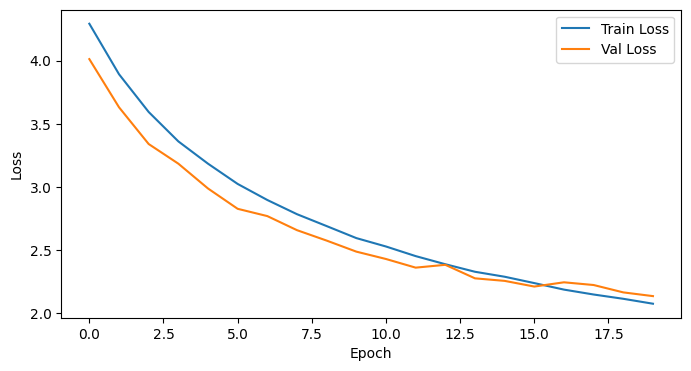

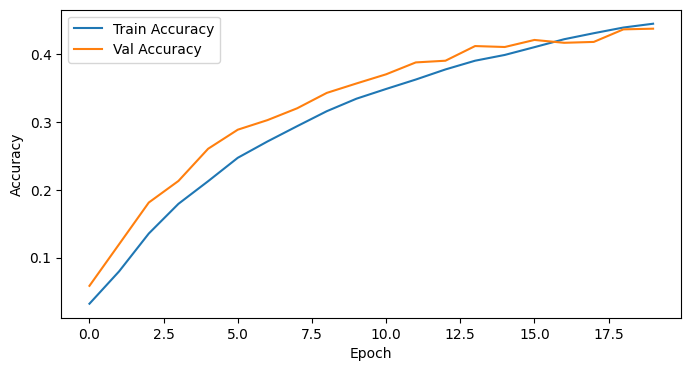

In [6]:
# Plotting Metrics

# Plot Loss
plt.figure(figsize=(8, 4))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot Accuracy
plt.figure(figsize=(8, 4))
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


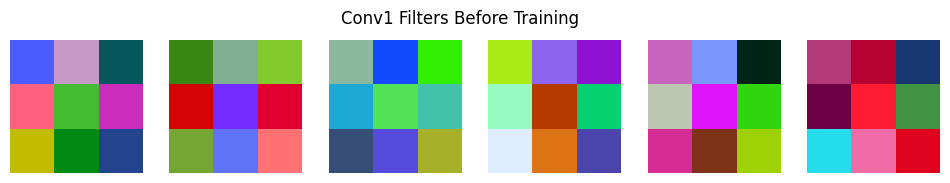

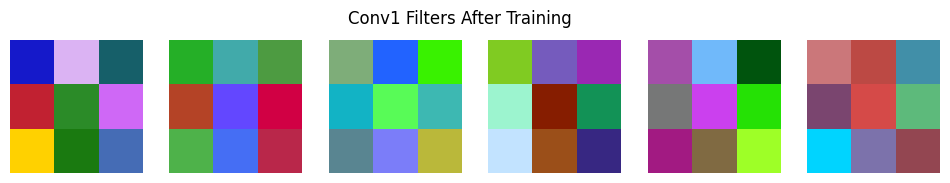

In [7]:
# Filter Visualization

# Helper function to plot a few convolutional filters
def plot_filters(filters, title):
    num_filters = min(6, filters.shape[0])
    fig, axes = plt.subplots(1, num_filters, figsize=(num_filters * 2, 2))
    for i in range(num_filters):
        filt = filters[i]
        # Normalize filter for display
        filt = (filt - filt.min()) / (filt.max() - filt.min())
        axes[i].imshow(np.transpose(filt, (1, 2, 0)))
        axes[i].axis('off')
    plt.suptitle(title)
    plt.show()

# Plot filters before training
plot_filters(initial_filters, 'Conv1 Filters Before Training')

# Plot filters after training
final_filters = model.conv1.weight.data.clone().cpu()
plot_filters(final_filters, 'Conv1 Filters After Training')


In [8]:
# Evaluation on Test Set

# Switch to evaluation mode
model.eval()

all_preds, all_labels = [], []

with torch.no_grad():
    for inputs, labels in testloader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = outputs.max(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

# Confusion matrix and classification report
cm = confusion_matrix(all_labels, all_preds)
report = classification_report(all_labels, all_preds, output_dict=True)

# Build metrics DataFrame
metrics_list = []
for i in range(100):
    tp = cm[i, i]
    fp = cm[:, i].sum() - tp
    fn = cm[i, :].sum() - tp
    tn = cm.sum() - (tp + fp + fn)
    f1 = report[str(i)]['f1-score']
    metrics_list.append({'class': i, 'TP': tp, 'FP': fp, 'FN': fn, 'TN': tn, 'F1': f1})

df_metrics = pd.DataFrame(metrics_list)
display(df_metrics)  # if using Jupyter

# Overall accuracy
overall_accuracy = (np.array(all_preds) == np.array(all_labels)).mean()
print(f"Overall Test Accuracy: {overall_accuracy:.4f}")


,class,TP,FP,FN,TN,F1
0,0,76,38,24,9862,0.710280
1,1,53,57,47,9843,0.504762
2,2,14,34,86,9866,0.189189
3,3,9,21,91,9879,0.138462
4,4,19,56,81,9844,0.217143
...,...,...,...,...,...,...
95,95,40,31,60,9869,0.467836
96,96,34,39,66,9861,0.393064
97,97,34,66,66,9834,0.340000
98,98,26,71,74,9829,0.263959


Overall Test Accuracy: 0.4373
